<span style="font-family:Papyrus; font-size:3em;">Lab: Cross Validation</span>


This lab develops codes and the workflow for doing cross validation of tellurium models. The running example is a simple Antimony model.

In [1]:
IS_COLAB = False
#
if IS_COLAB:
    !pip install matplotlib
    !pip install numpy
    !pip install tellurium
    !pip install SBstoat
    !pip install lmfit
    !pip install seaborn
#    
# Constants for standalone notebook
if not IS_COLAB:
    CODE_DIR = "/home/ubuntu/advancing-biomedical-models/common"
    DATA_DIR = "/home/ubuntu/advancing-biomedical-models/labs"
else:
    from google.colab import drive
    drive.mount('/content/drive')
    CODE_DIR = "/content/drive/MyDrive/Winter 2021/common"
    DATA_DIR = "/content/drive/MyDrive/Winter 2021/labs"
import sys
sys.path.insert(0, CODE_DIR)

In [2]:
# Make the packages usable in this notebook
import copy
import numpy as np
import pandas as pd
import tellurium as te
import matplotlib.pyplot as plt
from SBstoat.observationSynthesizer import ObservationSynthesizerRandomErrors
from SBstoat.namedTimeseries import NamedTimeseries, TIME
import lmfit

# Preliminaries

## Model

In [3]:
MODEL = """
A -> B; k1*A
B -> C; k2*B
C -> D; k3*C

A = 10
B = 0
C = 0
D = 0
k1 = 0.1
k2 = 0.2
k3 = 0.3
"""

## Constants

In [4]:
NOISE_STD = 1.0
END_TIME = 20
NUM_POINT = 100
LOWER = 0.01
UPPER = 1
# Model data
PARAMETER_DCT = {
    "k1": 0.1,
    "k2": 0.2,
    "k3": 0.3,
}
PARAMETER_NAMES = list(PARAMETER_DCT.keys())
ROAD_RUNNER = te.loada(MODEL)
dataArr = ROAD_RUNNER.simulate(0, END_TIME, NUM_POINT)
FITTED_TS = NamedTimeseries(namedArray=dataArr)


## Helper Functions

In [5]:
# Generator that constructs indices for training and test data
# for alternating between folds.
def foldGenerator(numPoint, numFold):
    """
    Generates pairs of trainining and test indices.
    
    Parameters:
    ----------
    numPoint: int
        number of time points
    numFold: int
        number of pairs of testIndices and trainIndices
    
    Returns:
    --------
    list of pairs of train indices, test indices
    """
    indices = range(numPoint)
    for remainder in range(numFold):
        testIndices = []
        for idx in indices:
            if idx % numFold == remainder:
                testIndices.append(idx)
        trainIndices = list(set(indices).difference(testIndices))
        yield trainIndices, testIndices
        
# Tests
numFold = 10
numPoint = 100
generator = foldGenerator(numPoint, numFold)
result = [(trainArr, testArr) for trainArr, testArr in generator]
assert(len(result) == numFold)
assert(isinstance(n, int) for n in result[0][0])

In [6]:
def plotTS(timeseries, ax=None, linetype="scatter", title="", isPlot=True):
    """
    Plots the variables in a timeseries.
    
    Parameters
    ----------
    timeseries: NamedTimeseries
    ax: Matplotlib.axes
    linetype: str
    title: str
    isPlot: bool
        Show the plot
    """
    if ax is None:
        fig, ax = plt.subplots(1)
    else:
        fig = None
    legend = []
    for col in timeseries.colnames:
        legend.append(col)
        if linetype == "scatter":
            _ = ax.scatter(timeseries[TIME], timeseries[col])
        else:
           _ = ax.plot(timeseries[TIME], timeseries[col])
    _ = ax.set_xlabel("time")
    _ = ax.set_title(title)
    _ = plt.legend(legend)
    if not isPlot:
        if fig is not None:
            fig.clear()
    return ax

# Smoke Test
_ = plotTS(FITTED_TS, linetype="line", title="Fitted Data", isPlot=False)

<Figure size 432x288 with 0 Axes>

## Construct Synthetic Data

In [7]:
def makeSyntheticData(fittedTS=FITTED_TS, std=NOISE_STD):
    synthesizer = ObservationSynthesizerRandomErrors(fittedTS=fittedTS, std=std)
    return synthesizer.calculate()

# Tests
observedTS = makeSyntheticData(fittedTS=FITTED_TS)
assert(len(observedTS) == len(FITTED_TS))

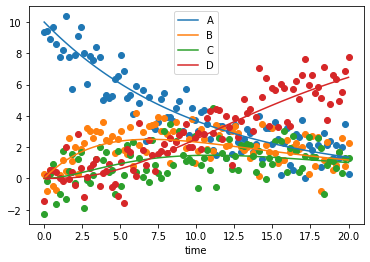

In [8]:
# Plot the data
OBSERVED_TS = makeSyntheticData()
ax = plotTS(FITTED_TS, linetype="line")
_ = plotTS(OBSERVED_TS, ax=ax)

# Writing a Fitter as a Class

It is common that you need to adapt your analysis codes to new requirements.
Cross validation imposes on fitting the ability to handle observational data that may not have all of the timepoints present in the
fitted data (simulation results).
Writing codes that are easy to adapt is an essential part of computational science.
It turns out that object oriented programming (**OOP**) greatly facilitates writing readable, testable, and extensible software.
This section provides a brief introdution to OOP and shows how to implement a fitter in OOP.

## Object Oriented Programming (OOP) in Brief

OOP is probably the most widely used approach to software design and implementation in the software industry.
It extends 3GL (third generation languages, those that have conditionals, for-loops, and functions) to consider
a new concept called a ``class``.

A ``class`` is an abstraction of a thing or entity, like a car.
An entity has **attributes** that describe it.
For example a car has a color, a number of doors, and an engine size.
Each of these as a  value associated with it, such as:
* color: red
* number of doors: 4
* engine size: 1.2
An entity also has **methods** which are operations that it can perform. For example,
a car can start, stop, and accelerate.

OOP strutures codes in terms of objects that are instances of classes.
The class is a template.
That is, a class specifies all of the attributes and methods, but not all of the attributes have values.
For example, a car class has attributes for color, number of doors, and engine capacity, but there are no values.
However, an instance of a car, might be red, with four doors, and a 1.2 L engine.

A very powerful capability of OOP is **inheritance**.
That is, we define a new class that has all of the attributes and methods of its parent and adds other attributes and methods.
For example, there may be a base car class that specifies color and engine size, and then separate child classes
for 2 doors and 4 doors.
Inheritance allows us to isolate common codes and so promotes reuse.

## OOP In Python

The python ``class`` keyword defines a new class.
For example

    class Car():
        pass

The definition of the class is the block of code that lies below the ``class`` statement
and is indented.
In this case, it is just ``pass``.
An object the class is created by using the class as a function or **constructor**.

    car = Car()
      
A class may have variables for each instance created.
These are specified as arguments of the constructor.
For example:

    car = Car(color, doors, engineSize)
    
If there are such arguments, then there must be a special function named ``__init__`` that takes these arguments.
That is, the class definition should look like:

    class Car():
    
        def __init__(self, color, doors, engineSize):
            self.color = color
            self.doors = doors
            self.engineSize = engineSize
            
Here, the ``Car`` class has the constructor function ``__init__`` with four arguments.
Three of the arguments appear when an object is constructed.
The first argument, ``self``, is used to identify the object that is created, the new instance of the class.

A class may have many methods (functions) that act on the object.
For example,

    class Car():
    
        def __init__(self, color, doors, engineSize):
            self.color = color
            self.doors = doors
            self.engineSize = engineSize
            
        def stop(self):
            print("The %s car has stopped!" % self.color)
            
        def turn(self, direction):
            print("The %s car has turned %s" % (self.color, direction)
            
The instance variables contained within the object and so provide a convenient way to encapsulate functions
that share data.

Below is another example of a class.

In [9]:
# A simple class
class Simple():
    def __init__(self, a, b):
        """
        a and b are used when constructing an instance of the class.
        """
        self.a = a
        self.b = b
        self.result = None  # placeholder
    def add(self):
        """
        calculaes the sum of a and b
        """
        self.result = self.a + self. b
        return self.result

In [10]:
# Using a class
simple = Simple(3, 4)  # This calls the __init__ method, with a=3 and b=4
print(simple.add())

7


In [11]:
# You can also retrieve the result from the properties of the object
print(simple.result)

7


## Writing and Testing a Fitter Class

In [12]:
class SimpleFitter(object):

    def __init__(self, model, observedTS, parameterNames,
                lower=LOWER, upper=UPPER, method="leastsq"):
        """
        model: str (Antimony Model)
        observedTS: NamedTimeseries
        paramterNames: list-str
        lower: float
            lower range for parameter value
        upper: float
            upper range for parameter value
        method: str
            optimizer method
        """
        self.rr = te.loada(model)
        self.observedTS = observedTS.copy()
        self.columns = list(self.observedTS.colnames)
        self.allColumns = self.observedTS.allColnames
        self.parameterNames = parameterNames
        self.colnames = self.observedTS.colnames
        self.lower = lower
        self.upper = upper
        self.value = (lower + upper)/2
        self.method = method
        # Internal variables
        self._fittedArr = None
        self._residuals = None
        # Results
        self.params = None
        self.fittedTS = self.observedTS.copy()
        self.residualsTS = None
        
    def mkParams(self):
        """
        Construct lmfit parameters for the parameters.
        """
        parameters = lmfit.Parameters()
        for parameterName in self.parameterNames:
            parameters.add(parameterName,
                          min=self.lower,
                          max=self.upper,
                          value=self.value)
        return parameters
        
    def calcResiduals(self, params):
        """
        Calculate residuals for the fit using the parameters.
        Update self.fittedTS.
        """
        self.rr.reset()  # Put back to time zero
        # Update the simulation parameters
        for name, value in params.valuesdict().items():
            self.rr[name] = value
        fittedArr = self.rr.simulate(0, self.observedTS.end,
                                    len(self.observedTS))
        self._fittedArr = fittedArr.copy()
        fittedArr = fittedArr[:, 1:]  # Delete time column
        observedArr = self.observedTS[self.colnames]
        self._residualsArr = observedArr - fittedArr
        residualsArr = self._residualsArr.flatten()
        return residualsArr
    
    def fit(self, params=None):
        if params is None:
            newParams = self.mkParams()
        else:
            newParams = params.copy()
        # Find the best parameters
        minimizer = lmfit.Minimizer(self.calcResiduals, newParams)
        minimizerResult = minimizer.minimize(method=self.method, max_nfev=100)
        # Record the results
        self.fittedTS = NamedTimeseries(array=self._fittedArr, colnames=self.allColumns)
        self.params = minimizerResult.params.copy()
        self.calcResiduals(self.params)  # Update the fitted and residuals
        self.residualsTS = self.observedTS.copy()        
        self.residualsTS[self.columns] = self._residualsArr
        
        
# Tests
fitter = SimpleFitter(MODEL, OBSERVED_TS, PARAMETER_NAMES)
params = fitter.mkParams()
k1ParameterValue = params.valuesdict()[PARAMETER_NAMES[0]]
assert(np.isclose(k1ParameterValue, (LOWER+UPPER)/2))
#
dataArr = fitter.calcResiduals(params)
assert(np.shape(dataArr) == (NUM_POINT*4,))
#
fitter.fit()
fittedResultDct = fitter.params.valuesdict()
for parameterName, parameterValue in fittedResultDct.items():
    #print(parameterName, parameterValue)
    assert(np.abs(parameterValue - PARAMETER_DCT[parameterName]) < 0.1)

In [13]:
fitter.fittedTS

                   A         B         C         D
time                                              
0.000000   10.000000  0.000000  0.000000  0.000000
0.202020    9.788003  0.208034  0.003882  0.000081
0.404040    9.580500  0.403955  0.014914  0.000632
0.606061    9.377396  0.588305  0.032230  0.002070
0.808081    9.178597  0.761604  0.055038  0.004761
...              ...       ...       ...       ...
19.191919   1.305983  1.351811  1.046237  6.295969
19.393939   1.278297  1.328927  1.032078  6.360698
19.595960   1.251197  1.306315  1.017941  6.424547
19.797980   1.224672  1.283976  1.003836  6.487516
20.000000   1.198709  1.261913  0.989771  6.549607

[100 rows x 4 columns]

# Timestamp Alignment

## Problem description

Suppose that we have observational data that has only a subset of the timestamps of the simulation data.
How do we change ``SimpleFitter`` to accommodate this?

In [14]:

observedSubTS = OBSERVED_TS[list(range(10))]
observedSubTS

                  A         B         C         D
time                                             
0.000000   9.372221  0.311794 -2.270626 -1.441684
0.202020   9.413923 -0.823451 -0.154277  0.151897
0.404040   8.928813  0.526887  0.251201  0.536315
0.606061   9.707831 -0.464598  0.904706  0.533908
0.808081   8.587453 -0.709129 -1.635673  0.426842
1.010101   7.768209  0.207391 -0.979675  0.005526
1.212121   8.237291  1.176656  1.746384 -0.169737
1.414141  10.371802  0.454775 -1.290317  2.015834
1.616162   7.788721  2.615606  0.478472 -0.044013
1.818182   5.743321  1.134832  1.542833  0.408697

In [15]:
FITTED_TS

                   A         B         C         D
time                                              
0.000000   10.000000  0.000000  0.000000  0.000000
0.202020    9.800007  0.195994  0.003920  0.000080
0.404040    9.604013  0.380306  0.015060  0.000621
0.606061    9.411939  0.553479  0.032548  0.002034
0.808081    9.223707  0.716030  0.055585  0.004678
...              ...       ...       ...       ...
19.191919   1.467255  1.251970  1.068275  6.212500
19.393939   1.437911  1.231151  1.054123  6.276815
19.595960   1.409154  1.210581  1.039992  6.340273
19.797980   1.380971  1.190262  1.025891  6.402876
20.000000   1.353353  1.170195  1.011827  6.464625

[100 rows x 4 columns]

We want to select the indices in ``FITTED_TS`` that have times corresonding to those in obseredSubTS.

In [16]:
observedSubTimes = observedSubTS[TIME]
observedSubTimes

array([0.        , 0.2020202 , 0.4040404 , 0.60606061, 0.80808081,
       1.01010101, 1.21212121, 1.41414141, 1.61616162, 1.81818182])

In [17]:
fittedTSTimes = FITTED_TS[TIME]
fittedTSTimes

array([ 0.        ,  0.2020202 ,  0.4040404 ,  0.60606061,  0.80808081,
        1.01010101,  1.21212121,  1.41414141,  1.61616162,  1.81818182,
        2.02020202,  2.22222222,  2.42424242,  2.62626263,  2.82828283,
        3.03030303,  3.23232323,  3.43434343,  3.63636364,  3.83838384,
        4.04040404,  4.24242424,  4.44444444,  4.64646465,  4.84848485,
        5.05050505,  5.25252525,  5.45454545,  5.65656566,  5.85858586,
        6.06060606,  6.26262626,  6.46464646,  6.66666667,  6.86868687,
        7.07070707,  7.27272727,  7.47474747,  7.67676768,  7.87878788,
        8.08080808,  8.28282828,  8.48484848,  8.68686869,  8.88888889,
        9.09090909,  9.29292929,  9.49494949,  9.6969697 ,  9.8989899 ,
       10.1010101 , 10.3030303 , 10.50505051, 10.70707071, 10.90909091,
       11.11111111, 11.31313131, 11.51515152, 11.71717172, 11.91919192,
       12.12121212, 12.32323232, 12.52525253, 12.72727273, 12.92929293,
       13.13131313, 13.33333333, 13.53535354, 13.73737374, 13.93

In [18]:
# Here's a hint to get started. Suppose we want to find the time value in fittedTSTimes that's closest to the 4th
# value in observedSubTime. This is a kind of distance measure.
(observedSubTimes[4] - fittedTSTimes)**2

array([6.52994592e-01, 3.67309458e-01, 1.63248648e-01, 4.08121620e-02,
       0.00000000e+00, 4.08121620e-02, 1.63248648e-01, 3.67309458e-01,
       6.52994592e-01, 1.02030405e+00, 1.46923783e+00, 1.99979594e+00,
       2.61197837e+00, 3.30578512e+00, 4.08121620e+00, 4.93827160e+00,
       5.87695133e+00, 6.89725538e+00, 7.99918376e+00, 9.18273646e+00,
       1.04479135e+01, 1.17947148e+01, 1.32231405e+01, 1.47331905e+01,
       1.63248648e+01, 1.79981635e+01, 1.97530864e+01, 2.15896337e+01,
       2.35078053e+01, 2.55076013e+01, 2.75890215e+01, 2.97520661e+01,
       3.19967350e+01, 3.43230283e+01, 3.67309458e+01, 3.92204877e+01,
       4.17916539e+01, 4.44444444e+01, 4.71788593e+01, 4.99948985e+01,
       5.28925620e+01, 5.58718498e+01, 5.89327620e+01, 6.20752984e+01,
       6.52994592e+01, 6.86052444e+01, 7.19926538e+01, 7.54616876e+01,
       7.90123457e+01, 8.26446281e+01, 8.63585348e+01, 9.01540659e+01,
       9.40312213e+01, 9.79900010e+01, 1.02030405e+02, 1.06152433e+02,
      

## An Approach

That is, we want to find the index for the array element that is 0.
We can do this by sorting the indices of fittedTSTimes by their distance from designated time in observedSubTimes.

In [19]:
values = (observedSubTimes[4] - fittedTSTimes)**2
def finder(index):
    return values[index]
sorted(range(len(values)), key=finder)

[4,
 3,
 5,
 2,
 6,
 1,
 7,
 0,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99]

In [20]:
def selectCompatibleIndices(bigTimes, smallTimes):
    """
    Finds the indices such that smallTimes[n] is close to bigTimes[indices[n]]
    
    Parameters
    ----------
    bigTimes: np.ndarray
    smalltimes: np.ndarray
    
    Returns
    np.ndarray
    """
    indices = []
    for idx in range(len(smallTimes)):
        distances = (bigTimes - smallTimes[idx])**2
        def getValue(k):
            return distances[k]
        thisIndices = sorted(range(len(distances)), key=getValue)
        indices.append(thisIndices[0])
    return np.array(indices)

# Tests
indices = selectCompatibleIndices(FITTED_TS[TIME], observedSubTS[TIME])
assert(len(indices) == len(observedSubTS))
for i, index in enumerate(indices):
    assert(index == i)

## Revise the residuals calculation

The only method impacted is ``calcResiduals``.
Let's figure this out incrementally.
Start by doing the residuals calculation using ``observedSubTS`` and ``fittedArr``.

In [21]:
colnames = FITTED_TS.colnames
fittedArr = FITTED_TS[FITTED_TS.allColnames]
observedTS = observedSubTS.copy()
# Fragment of the residual calculation
#fittedArr = fittedArr[:, 1:]
indices = selectCompatibleIndices(FITTED_TS[TIME], observedTS[TIME])
observedArr = observedTS[colnames]
fittedSubArr = fittedArr[indices, 1:]
residualsArr = observedArr - fittedSubArr
residualsArr = residualsArr.flatten()

# Fitting With Timestamp Alignment

There's no assurance that the observational data have the same timestamps as the simulation data.
Solving this problem in general requires some sophistication.
For now, we will assume that the observational data contains a subset of the timestamps.

In [22]:
# Modified calcResduals
class AligningFitter(SimpleFitter):
    """Does fitting with aligning fitted values to timestamps of observed values."""
    
    def __init__(self, model, observedTS, parameterNames, endTime=None, numPoint=None, **kwargs):
        """
        model: str (Antimony Model)
        observedTS: NamedTimeseries
        paramterNames: list-str
        endTime: float
            ending time for the simulation
        numPoint: int
            number of points in the simulation
        """
        super().__init__(model, observedTS, parameterNames, **kwargs)
        self.endTime = endTime
        if self.endTime is None:
            self.endTIme = observedTS.end
        self.numPoint = numPoint
        if self.numPoint is None:
            self.numPoint = len(observedTS)
    
    @staticmethod
    def selectCompatibleIndices(bigTimes, smallTimes):
        """
        Finds the indices such that smallTimes[n] is close to bigTimes[indices[n]]

        Parameters
        ----------
        bigTimes: np.ndarray
        smalltimes: np.ndarray

        Returns
        np.ndarray
        """
        indices = []
        for idx in range(len(smallTimes)):
            distances = (bigTimes - smallTimes[idx])**2
            def getValue(k):
                return distances[k]
            thisIndices = sorted(range(len(distances)), key=getValue)
            index = thisIndices[0]
            if isinstance(index, np.generic):
                index = np.asscalar(index)
            indices.append(index)
        return indices
        
    def calcResiduals(self, params):
        self.rr.reset()  # Put back to time zero
        # Update the simulation parameters
        for name, value in params.valuesdict().items():
            self.rr[name] = value
        fittedArr = self.rr.simulate(0, self.endTime, self.numPoint)
        self._fittedArr = fittedArr.copy()
        indices = AligningFitter.selectCompatibleIndices(fittedArr[:, 0], self.observedTS[TIME])
        fittedArr = fittedArr[indices, 1:]  # Delete time column
        observedArr = self.observedTS[self.colnames]
        self._residualsArr = observedArr - fittedArr
        residualsArr = self._residualsArr.flatten()
        return residualsArr
    
# Tests
size = 50
observedSubTS = OBSERVED_TS[list(range(size))]
fitter = AligningFitter(MODEL, observedSubTS, PARAMETER_NAMES)
fitter.fit()
assert(len(fitter.observedTS) == size)
assert(len(fitter.params.valuesdict()) == 3)

In [23]:
def analyzeQuality(numSample):
    """
    Analyzes the quality of a fit for the number of points in an observed timeseries.
    
    Parameters
    ----------
    numSample: int
    
    Returns
    -------
    float: sum of squared differences from true parameter values
    pd.DataFrame: values of true and estimated parameters
    """
    TRUE = "true"
    ESTIMATED = "estimated"
    if len(OBSERVED_TS) < numSample:
        raise ValueError("numSample cannot exceed %d" % len(OBSERVED_TS))
    # Select a random sample of the observational data
    numPoint = len(OBSERVED_TS)
    randomIndices = np.random.permutation(list(range(numPoint)))
    randomIndices = randomIndices[:numSample]
    observedSubTS = OBSERVED_TS[randomIndices.tolist()]
    # Fit the data
    fitter = AligningFitter(MODEL, observedSubTS, PARAMETER_NAMES,
                           numPoint=numPoint, endTime=OBSERVED_TS.end)
    fitter.fit()
    # Evaluate the fit quality
    dct = {TRUE: PARAMETER_DCT.values(), ESTIMATED: fitter.params.valuesdict().values()}
    df = pd.DataFrame(dct)
    df.index = PARAMETER_DCT.keys()
    trueValues = np.array(df[TRUE])
    estimatedValues = np.array(df[ESTIMATED])
    rsq = 1 - np.var(trueValues-estimatedValues)/np.var(trueValues)
    rsq = max(0, rsq)
    return rsq, df

# Tests
rsq, df = analyzeQuality(100)
assert(rsq > 0.95)
assert(len(df) == len(PARAMETER_DCT))

In [24]:
rsq, df = analyzeQuality(50)
print("SSQ Difference: %2.4f" % rsq)
print("\nValues\n%s" % str(df))

SSQ Difference: 0.9448

Values
    true  estimated
k1   0.1   0.109469
k2   0.2   0.173042
k3   0.3   0.316964


# Cross Validation for Simulation Models

## Pseudo Code

1. Create training and test data for the folds
1. For the training and test data
   1. Fit to training data
   1. predictedValues = Fitted values that correspond to test data
   1. Calculate $R^2$ from test data and predictedValues
1. Report the parameters and $R^2$ for each fold.

## Implementation

In [25]:
class CrossValidator():
    """Performs cross validation using parameter fitting. Reports parameters by fold and R2."""
    
    # Dataframe columns and dictionary keys
    PREDICTED = "predicted"
    TRUE = "true"
    FOLD = "fold"
    RSQ = "rsq"
    PARAMETER = "parameter"
    
    def __init__(self, numFold, model, observedTS, parameterNames, trueParameterDct=None, **kwargs):
        """
        numFold: int
            number of folds
        model: str (Antimony Model)
        observedTS: NamedTimeseries
        paramterNames: list-str
        trueParameterDct: dict
            key: parameter name, value: parameter value
        kwargs: dict
           optional arguments passed to fitter
        """
        self.numFold = numFold
        self.model = model
        self.observedTS = observedTS.copy()
        self.parameterNames = parameterNames
        self.colnames = self.observedTS.colnames
        self.kwargs = kwargs
        self.trueParameterDct = trueParameterDct
        self.parametersCol = []
        self.rsqs = []

    @staticmethod
    def _calcRsq(observedTS, fittedTS):
        columns = observedTS.colnames
        residualsArr = observedTS[columns] - fittedTS[columns]
        rsq = 1 - np.var(residualsArr)/np.var(observedTS[columns])
        return rsq

    def execute(self):
        numPoint = len(self.observedTS)
        generator = foldGenerator(numPoint, self.numFold)
        for trainIndices, testIndices in generator:
            fitter = AligningFitter(self.model, self.observedTS[trainIndices],
                                  self.parameterNames, endTime=self.observedTS.end,
                                  numPoint=numPoint, **self.kwargs)
            fitter.fit()
            self.parametersCol.append(fitter.params.copy())
            rsq = self._calcRsq(self.observedTS[testIndices], fitter.fittedTS[testIndices])
            self.rsqs.append(rsq)

    def reportParameters(self):
        """
        Constructs a report for the parameter values by fold.
        
        Returns
        -------
        pd.DataFrame
        """
        if self.trueParameterDct is  None:
            raise ValueError("Must construct CrossValidator with trueParameterDct")
        # Construct parameter information
        keys = [CrossValidator.FOLD, CrossValidator.TRUE, CrossValidator.PREDICTED, CrossValidator.PARAMETER]
        dct = {}
        for key in keys:
            dct[key] = []
        for fold in range(len(self.parametersCol)):
            for parameterName in self.parameterNames:
                dct[CrossValidator.FOLD].append(fold)
                dct[CrossValidator.PARAMETER].append(parameterName)
                dct[CrossValidator.TRUE].append(self.trueParameterDct[parameterName])
                dct[CrossValidator.PREDICTED].append(self.parametersCol[fold].valuesdict()[parameterName])
        reportDF = pd.DataFrame(dct)
        #
        return reportDF
    
    def reportRsq(self):
        return pd.DataFrame({CrossValidator.RSQ: self.rsqs})
    
# TESTS
#  _calcRsq
rsq = CrossValidator._calcRsq(OBSERVED_TS, OBSERVED_TS)
assert(np.isclose(rsq, 1.0))
#  execute
numFold = 5
validator = CrossValidator(numFold, MODEL, OBSERVED_TS, PARAMETER_NAMES,
                           trueParameterDct=PARAMETER_DCT)
validator.execute()
assert(len(validator.rsqs) == numFold)
assert(len(validator.parametersCol) == numFold)
assert(isinstance(validator.parametersCol[0], lmfit.Parameters))
#  reportParameters
df = validator.reportParameters()
for key in [CrossValidator.FOLD, CrossValidator.TRUE, CrossValidator.PREDICTED, CrossValidator.PARAMETER]:
    assert(key in df.columns)
assert(len(df) > 0)
#  reportRsq
df = validator.reportRsq()
assert(CrossValidator.RSQ in df.columns)
assert(len(df) > 0)

# Analysis With Cross Validation

In [26]:
for numFold in [5, 10, 50, 100]:
    validator = CrossValidator(numFold, MODEL, OBSERVED_TS, PARAMETER_NAMES, trueParameterDct=PARAMETER_DCT)
    validator.execute()
    averageRsq  = np.mean(validator.rsqs)
    print("Num Fold: %d  Avg Rsq: %2.2f" % (numFold, averageRsq))

Num Fold: 5  Avg Rsq: 0.79
Num Fold: 10  Avg Rsq: 0.79
Num Fold: 50  Avg Rsq: 0.77
Num Fold: 100  Avg Rsq: 0.63


**Questions**
1. Why does average $R^2$ *decrease* with the number of folds?
1. What happens if there is more variablility in the data? Less variability in the data?
1. Write a new script that evaluates the combined effects of the number folds and the noise in the observed time series.

In [47]:
def analyzeNoiseFold(noiseStds, numFolds):
    """
    Evaluates the impact on R2 of the number of noise std and the number of folds
    
    Parameters
    ----------
    noiseStds: list-float
    numFolds: list-int
    
    Returns
    -------
    pd.DataFrame
        columns: std, numfold, avgrsq
    """
    STD = "std"
    NUMFOLD = "numfold"
    RSQ = "avgrsq"
    COLUMNS = [STD, NUMFOLD, RSQ]
    #
    dct = {c: [] for c in COLUMNS}
    #
    for std in noiseStds:
        observedTS = makeSyntheticData(std=std)
        for numFold in numFolds:
            validator = CrossValidator(numFold, MODEL, observedTS, PARAMETER_NAMES, trueParameterDct=PARAMETER_DCT)
            validator.execute()
            averageRsq  = np.mean(validator.rsqs)
            dct[STD].append(std)
            dct[NUMFOLD].append(numFold)
            dct[RSQ].append(averageRsq)
    return pd.DataFrame(dct)

# Tests
df = analyzeNoiseFold([0.5, 1.5], [5, 10, 100])
assert(len(df) > 0)
assert(sum(df["avgrsq"]) > 0)

In [48]:
df

,std,numfold,avgrsq
0,0.5,5,0.944788
1,0.5,10,0.944910
2,0.5,100,0.891683
3,1.5,5,0.674593
4,1.5,10,0.677491
5,1.5,100,0.375822
